In [1]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

from pathlib import Path
from dataclasses import dataclass


from matplotlib import pyplot as plt
%matplotlib ipympl
import numpy as np
import cv2

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [3]:
def get_landmarker_results_from_video(
    video_path, options, start_time_ms=None, end_time_ms=None
):
    cap = cv2.VideoCapture(video_path)
    if start_time_ms:
        cap.set(cv2.CAP_PROP_POS_MSEC, start_time_ms)
    pose_landmarker_results = []
    landmarker = mp.tasks.vision.PoseLandmarker.create_from_options(
        options
    )
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"Can't read frame. Skipping...")
            break
        curr_frame_timestamp_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
        if end_time_ms and curr_frame_timestamp_ms >= end_time_ms:
            break
        downscaled_frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=cv2.cvtColor(downscaled_frame, cv2.COLOR_BGR2RGB),
        )
        pose_landmarker_result = landmarker.detect_for_video(
            mp_image, int(cap.get(cv2.CAP_PROP_POS_MSEC))
        )
        pose_landmarker_results.append(
            {
                "timestamp_ms": curr_frame_timestamp_ms,
                "original_frame": downscaled_frame,
                "landmarker_results": pose_landmarker_result,
            }
        )
    cap.release()
    return pose_landmarker_results

In [4]:
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    for pose_landmarks in pose_landmarks_list:
        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend(
            [
                landmark_pb2.NormalizedLandmark(
                    x=landmark.x, y=landmark.y, z=landmark.z
                )
                for idx, landmark in enumerate(pose_landmarks)
            ]
        )
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
        )
    return annotated_image

In [5]:
model_path = "assets/pose_landmarker_lite.task"
video_path = "media/slowmo/jab_front_side_rear.mp4"
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO,
    output_segmentation_masks=True,
)
pose_landmarker_results = get_landmarker_results_from_video(
    video_path, options, end_time_ms=25 * 1e3
)

I0000 00:00:1757986105.898560 17032357 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1757986106.002228 17034853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1757986106.014316 17034853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/dhruvgarg/Documents/boxing_dynamics/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [10]:
first_frame = pose_landmarker_results[0]["original_frame"]
height, width, _ = first_frame.shape
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()
out = cv2.VideoWriter(
    "media/annotated/jab_front_side_rear_slowmo.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width * 2, height),  # width doubled for side-by-side
)


for frame_data in pose_landmarker_results:
    original_frame = cv2.cvtColor(
        frame_data["original_frame"], cv2.COLOR_BGR2RGB
    )
    landmarks_frame = np.copy(original_frame)
    alpha = 0.5
    landmarks_frame = cv2.addWeighted(
        landmarks_frame,
        alpha,
        np.zeros_like(landmarks_frame),
        1 - alpha,
        0,
    )
    landmarks_frame = draw_landmarks_on_image(
        landmarks_frame, frame_data["landmarker_results"]
    )

    side_by_side = np.concatenate(
        (original_frame, landmarks_frame), axis=1
    )

    side_by_side_bgr = cv2.cvtColor(side_by_side, cv2.COLOR_RGB2BGR)
    out.write(side_by_side_bgr)
out.release()

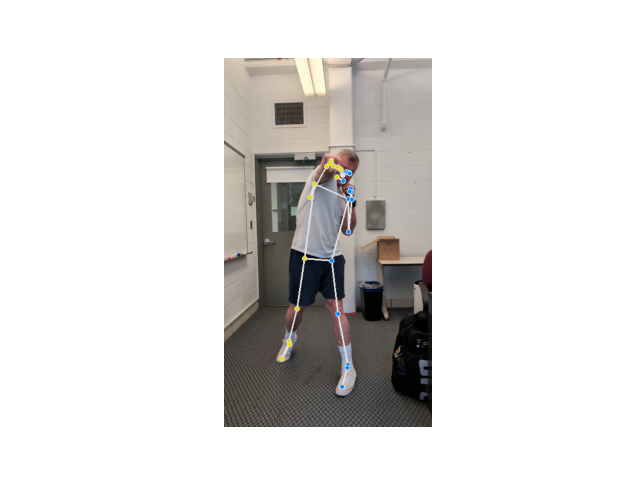

In [83]:
results_dict = pose_landmarker_results[100]
landmarkers = results_dict["landmarker_results"]
original_frame = results_dict["original_frame"]
height, width, _ = original_frame.shape
force_x_img, force_y_img = (
    int(landmarkers.pose_landmarks[0][25].x * width),
    int(landmarkers.pose_landmarks[0][25].y * height),
)
cv2.arrowedLine(
    original_frame,
    pt1=(force_x_img, force_y_img),
    pt2=(force_x_img + 30, force_y_img),
    color=(0, 0, 255),
    thickness=1,
)
original_frame_rgb = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)
annotated_frame = draw_landmarks_on_image(
    original_frame_rgb,
    landmarkers,
)
plt.close("all")
plt.imshow(annotated_frame)
plt.axis("off")  # hide axes
plt.show()

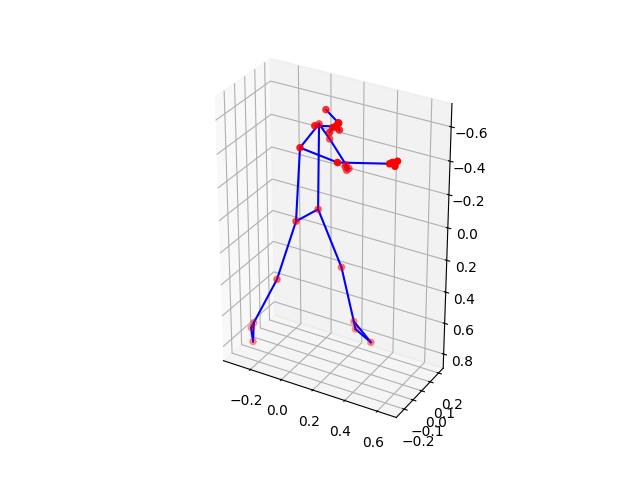

In [82]:
plt.close("all")
pose_world_landmarkers = landmarkers.pose_world_landmarks
x = np.array([lm.x for lm in pose_world_landmarkers[0]])
y = np.array([lm.y for lm in pose_world_landmarkers[0]])
z = np.array([lm.z for lm in pose_world_landmarkers[0]])
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, z, y, s=20, c="red")
from mediapipe.python.solutions import pose as mp_pose

for connection in mp_pose.POSE_CONNECTIONS:
    start, end = connection
    ax.plot(
        [x[start], x[end]],
        [z[start], z[end]],
        [y[start], y[end]],
        color="blue",
    )
ax.invert_zaxis()
ax.set_aspect("equal")